In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

df = pd.read_csv('../../data/DATASET_FINAL_DIVORCIOS.csv')
df.head()


,Departamento,Divorcios,Denuncias,Sexo_Hombre,Sexo_Mujer,0 a 4,5 a 9,10 a 14,15 a 19,20 a 24,25 a 29,30 a 34,35 a 39,40 a 44,45 a 49,50 a 54,55 a 59,60 a 64,65 y más,Ignorado_edad
0,República,"91,536","484,607","52,835","431,772",530,"1,015","3,359","39,506","87,672","90,822","79,107","59,870","40,395","25,711","16,870","10,963","7,898","14,401","6,488"
1,Guatemala,"35,192","90,889","9,909","80,980",99,190,630,"7,409","16,443","17,034","14,837","11,229","7,576","4,822","3,164","2,056","1,481","2,701","1,217"
2,El Progreso,"1,577","15,295","1,668","13,627",17,32,106,"1,247","2,767","2,866","2,497","1,890","1,275",811,532,346,249,455,205
3,Sacatepéquez,"1,968","22,713","2,476","20,237",25,48,157,"1,852","4,109","4,257","3,708","2,806","1,893","1,205",791,514,370,675,304
4,Chimaltenango,"1,801","26,664","2,907","23,757",29,56,185,"2,174","4,824","4,997","4,353","3,294","2,223","1,415",928,603,435,792,357


# Limpieza de datos

In [25]:
# Eliminar filas de totales nacionales si existen
df = df[df['Departamento'] != 'República']

# Reemplazar comas por nada y convertir a entero
cols_numericas = df.columns.drop('Departamento')
df[cols_numericas] = df[cols_numericas].replace(',', '', regex=True).astype(int)

# Crear la variable objetivo: "Categoria_Divorcios"
promedio_nacional = df['Divorcios'].mean()
df['Categoria_Divorcios'] = df['Divorcios'].apply(
    lambda x: 'alto' if x > promedio_nacional else ('bajo' if x < promedio_nacional else 'neutro')
)

In [26]:
# Verificar valores únicos
df['Categoria_Divorcios'].value_counts()

Categoria_Divorcios
bajo    20
alto     3
Name: count, dtype: int64

In [18]:
df.head()

,Departamento,Divorcios,Denuncias,Sexo_Hombre,Sexo_Mujer,0 a 4,5 a 9,10 a 14,15 a 19,20 a 24,...,30 a 34,35 a 39,40 a 44,45 a 49,50 a 54,55 a 59,60 a 64,65 y más,Ignorado_edad,Categoria_Divorcios
1,Guatemala,35192,90889,9909,80980,99,190,630,7409,16443,...,14837,11229,7576,4822,3164,2056,1481,2701,1217,alto
2,El Progreso,1577,15295,1668,13627,17,32,106,1247,2767,...,2497,1890,1275,811,532,346,249,455,205,bajo
3,Sacatepéquez,1968,22713,2476,20237,25,48,157,1852,4109,...,3708,2806,1893,1205,791,514,370,675,304,bajo
4,Chimaltenango,1801,26664,2907,23757,29,56,185,2174,4824,...,4353,3294,2223,1415,928,603,435,792,357,bajo
5,Escuintla,4131,15404,1679,13725,17,32,107,1256,2787,...,2515,1903,1284,817,536,348,251,458,206,alto


# Visualizacion de datos

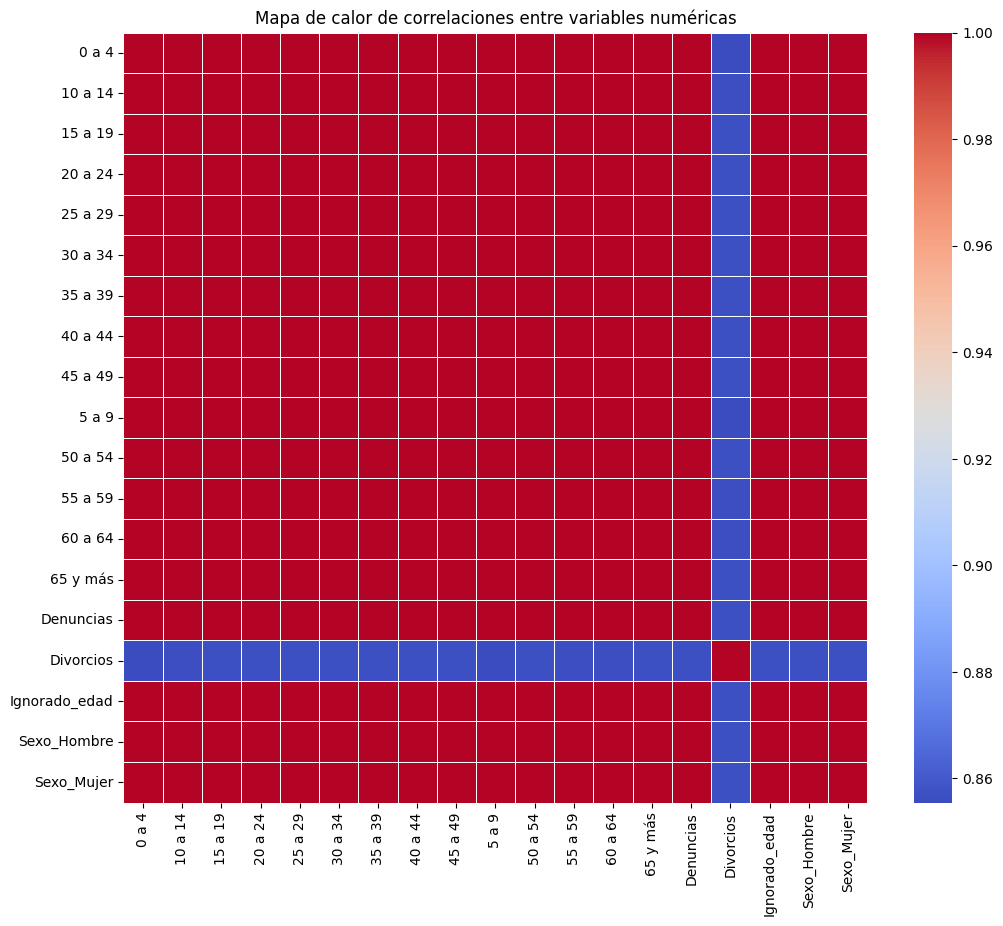

In [27]:
# Definir columnas numéricas excluyendo las categóricas
cols_numericas = df.columns.difference(['Departamento', 'Categoria_Divorcios'])

# Convertir las columnas numéricas
df[cols_numericas] = df[cols_numericas].replace(',', '', regex=True).astype(int)

# Crear variable objetivo (si no está creada ya)
if 'Categoria_Divorcios' not in df.columns:
    promedio_nacional = df['Divorcios'].mean()
    df['Categoria_Divorcios'] = df['Divorcios'].apply(
        lambda x: 'alto' if x > promedio_nacional else ('bajo' if x < promedio_nacional else 'neutro')
    )

# Visualización: Mapa de calor de correlaciones
correlation_matrix = df[cols_numericas].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Mapa de calor de correlaciones entre variables numéricas")
plt.show()

Este análisis revela una alta colinealidad entre los grupos etarios y otras variables poblacionales, lo cual es esperado

# Modelo SVM

In [34]:
# Variables X e y
X = df.drop(columns=['Departamento', 'Categoria_Divorcios', 'Divorcios'])  # No usamos Divorcios porque define la etiqueta
y = df['Categoria_Divorcios']

# Normalización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Codificación de la clase
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

In [35]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

# Modelo SVM con kernel RBF
svm_model = SVC(kernel='rbf', C=1, gamma='scale', decision_function_shape='ovo')

# Validación cruzada estratificada 5-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(svm_model, X_scaled, y_encoded, cv=cv, scoring='accuracy')

# Promedio y desviación estándar
scores_mean = np.mean(scores)
scores_std = np.std(scores)

print("Accuracies por fold:", scores)
print("Promedio:", scores_mean)
print("Desviación estándar:", scores_std)

Accuracies por fold: [0.8 0.8 0.8 1.  1. ]
Promedio: 0.8800000000000001
Desviación estándar: 0.09797958971132709


c:\Users\thiag\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


In [36]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
svm_model.fit(X_train, y_train)

# Predicción y métricas
y_pred = svm_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)
accuracy = accuracy_score(y_test, y_pred)

print("Matriz de confusión:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Reporte de clasificación:\n", report)


Matriz de confusión:
 [[0 1]
 [0 6]]
Accuracy: 0.8571428571428571
Reporte de clasificación:
               precision    recall  f1-score   support

        alto       0.00      0.00      0.00         1
        bajo       0.86      1.00      0.92         6

    accuracy                           0.86         7
   macro avg       0.43      0.50      0.46         7
weighted avg       0.73      0.86      0.79         7



c:\Users\thiag\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thiag\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thiag\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo